In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Averaging an IV measurement to reduce noise

There are two important observations about the IV traces we measure: 

* First, since we are measuring vs time, a given data file contains several (about 2.5) IV traces, ie. sawtooth ramps of the current
* Second: the RedPitaya is able to sample these at a very high rate (16,384 points per trace!) which means we have a very high density of points

As you see, the IV curves do contain noise: both "uniform" noise, ie. some random fluctuations of the measured voltage from the noise of the amplifier, as well as some "jumps" sometimes, when the SQUID experiences some noise. 

Since each measurement contains multiple traces, and each trace contains *loads* of points, we can actually average this data to produce lower noise plots (although, of course, with fewer data points).

Because of the way the data is arranged in the file, this is a bit tricky to do since the current bias of a given point does not just increase with point number, but ramps up and down and up and down. 

To solve this, we can "sort" the data in python based on the applied bias current. Once we have done that, it become easy to lower the noise by averaging adjacent data points. It also makes it easy to take the numerical derivative of the data to calculate the differential resistance $dV / dI$. 

This is shown in the following cells:

Text(0, 0.5, 'Measured voltage $V$ ($\\mu$A)')

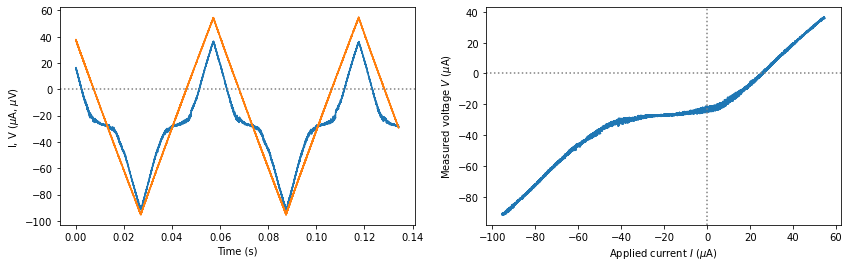

In [27]:
file =  "mrsquid_V-I_2020-10-16-12_05_03.dat"
t,i,v = np.loadtxt(file, unpack=True)

plt.subplots(figsize=(14,4))
plt.subplot(121)
plt.plot(t,v)
plt.plot(t,i)
plt.xlabel("Time (s)")
plt.ylabel("I, V ($\mu$A, $\mu$V)")
plt.axhline(0,ls=':',c='grey')
plt.subplot(122)
plt.plot(i,v)
plt.axhline(0,ls=':',c='grey')
plt.axvline(0,ls=':',c='grey')
plt.xlabel("Applied current $I$ ($\mu$A)")
plt.ylabel("Measured voltage $V$ ($\mu$A)")

Here, we can see the multiple "sweeps" that are contained in the data file. 

We will first sort the data:

In [35]:
# The number of points we will average together
n=200

# This returns an array of the index order that will sort the dataset according to the applied current
ind = np.argsort(i)

i_s = i[ind]
v_s = v[ind]

Let's take a look at what that code did to our data arrays:

Text(0.5, 1.0, 'After Sorting')

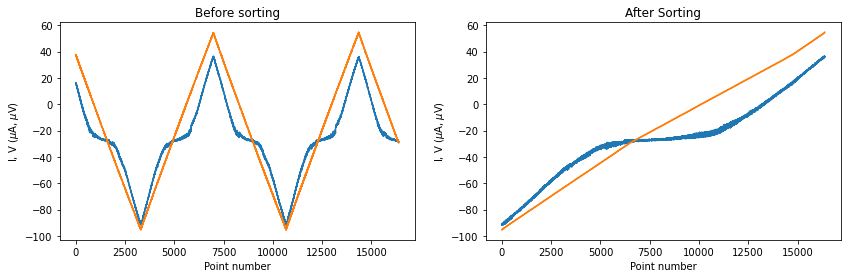

In [39]:
plt.subplots(figsize=(14,4))
plt.subplot(121)
plt.plot(v)
plt.plot(i)
plt.xlabel("Point number")
plt.ylabel("I, V ($\mu$A, $\mu$V)")
plt.title("Before sorting")
plt.subplot(122)
plt.plot(v_s)
plt.plot(i_s)
plt.xlabel("Point number")
plt.ylabel("I, V ($\mu$A, $\mu$V)")
plt.title("After Sorting")

Now that we have sorted, we are ready to average. 

For the averaging, we will use "bin averaging". This type of averaging preserves the statistical independence of the measurement samples, which is **crucially** important if you are going to fit the data later! 

*Warning: **NEVER** fit data after low pass filtering it or using a moving average, it will cause your fit to report incorrect errors on your fit parameters!*

In [28]:
# An appropriate averaging code to use 
# (see https://github.com/gsteele13/gary-misc-notebooks/blob/master/Bin%20Average.md)

def binaverage(x, navg):
    N = len(x) // navg
    return np.average(np.reshape(x[0:N*navg],(N,navg)),axis=1)

Let's use it on our sorted arrays:

In [40]:
# We use this array to index the original arrays, and then send that to the binaverage routine
i_f2 = binaverage(i_s,n)
v_f2 = binaverage(v_s,n)

And now take a look:

Text(0, 0.5, 'Measured voltage $V$ ($\\mu$A)')

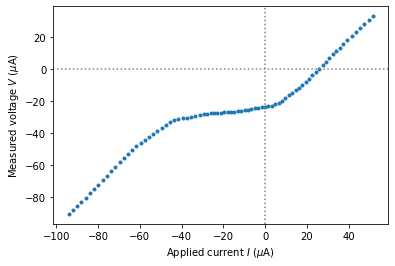

In [41]:
plt.plot(i_f2,v_f2, '.')
plt.axhline(0,ls=':',c='grey')
plt.axvline(0,ls=':',c='grey')
plt.xlabel("Applied current $I$ ($\mu$A)")
plt.ylabel("Measured voltage $V$ ($\mu$A)")

We can see that this is much lower noise! Also fewer points, but that is OK: you cannot reduce the noise by averaging without reducing the (statistically independent) number of points in your dataset.

With lower noise, we can also take the derivative! Taking the derivative of noisy data will always result in an even noiser curve, so in this case we will do extra averaging (you can play with the parameter to see how it changes things):

Text(0, 0.5, 'Differential resistance dV/dI (Ohms)')

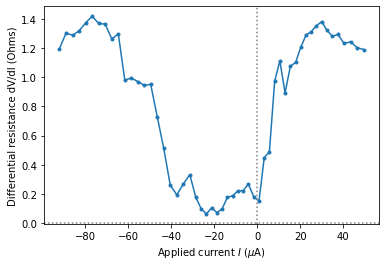

In [43]:
# Now also an example of taking the derivative
n=300

ind = np.argsort(i)

# Sort and filter in one step
i_f = binaverage(i[ind],n)
v_f = binaverage(v[ind],n)

# We use np.diff to make an array that calculates the difference of adjacent point
# Note that since the x-axis (i) is not uniformly gridded, we need to calculate for each 
# specific point what the difference is...
di = np.diff(i_f)
dv = np.diff(v_f)

# Now we calculate R
R = dv/di

# Note that R has one less point than i: we need to define a new i vector with fewer points
# This line of code will do that and make our calculation above equivalent to the center
# difference approximation of the derivative
i_R = (i_f[1:]+i_f[:-1])/2

plt.plot(i_R,R, '.-')
plt.axhline(0,ls=':',c='grey')
plt.axvline(0,ls=':',c='grey')
plt.xlabel("Applied current $I$ ($\mu$A)")
plt.ylabel("Differential resistance dV/dI (Ohms)")

If you want to get even *lower* noise on your IV curve, and on your $dV/dI$ curves, you can take several measurements in a row in the software, load them all in python, append all the `i` and `v` arrays together: you will then have more points in your dataset to start with, which means you can do more averaging, getting less noise in your averaged curves. 